# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 




**Цель исследования:**
1. Определить рыночную стоимость объектов недвижемости
2. Построить автоматизированную систему, которая отследит аномалии и мошенические действия
3. Установить, какие факторы влияют на ценообразование стоимости квартир

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Изучение общей информации о данных

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

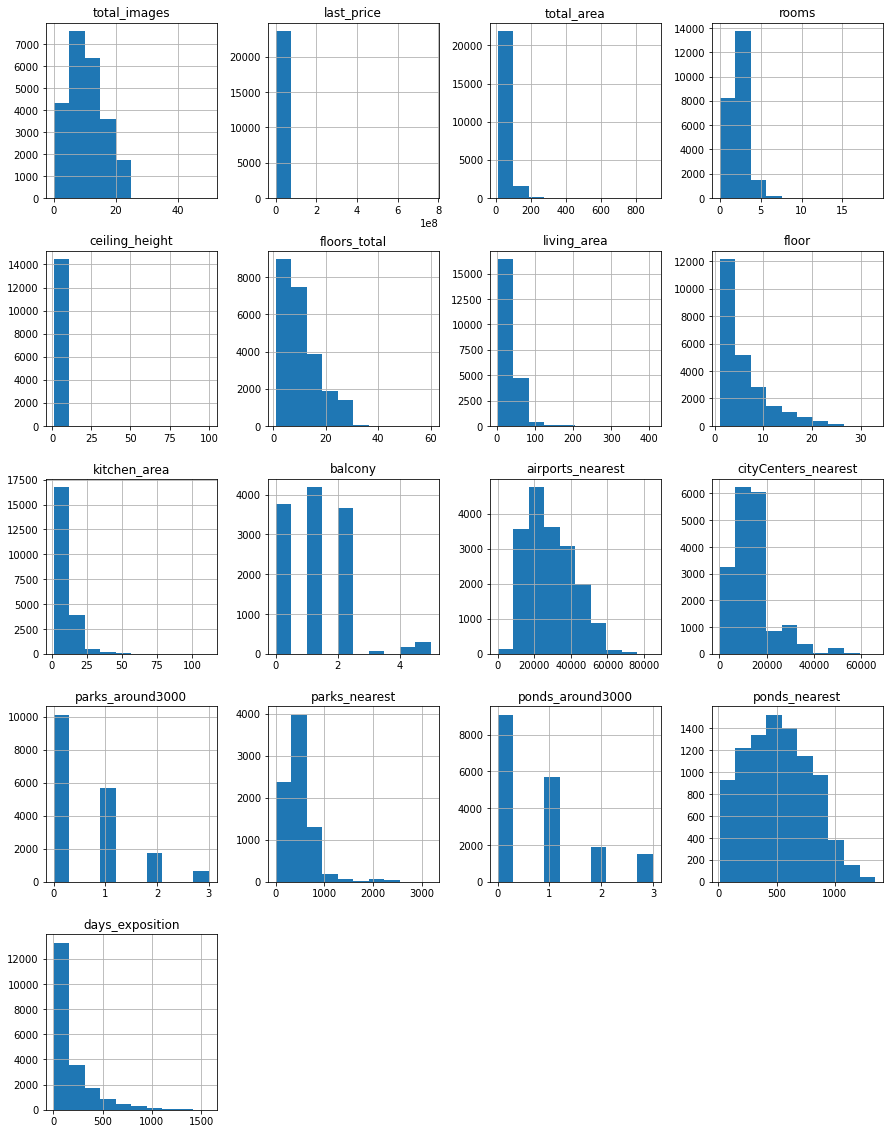

In [5]:
data.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

In [6]:
def calc_nan(data):
    return pd.DataFrame({'columns' : data.columns, 'cnt' : data.isna().sum().values, 'prc' : data.isna().mean().values}).style.background_gradient('coolwarm')

#### Устранение дубликатов

In [7]:
data.shape

(23699, 22)

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(23699, 22)

#### Работа с пропусками (категориальные переменные)

In [10]:
calc_nan(data)

,columns,cnt,prc
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,9195,0.387991
6,floors_total,86,0.003629
7,living_area,1903,0.080299
8,floor,0,0.000000
9,is_apartment,20924,0.882906


In [11]:
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
677,10,4900000.0,75.00,2018-02-08T00:00:00,3,2.7,10.0,45.90,5,NaN,False,False,10.40,2.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3444,14,8780000.0,99.30,2017-09-27T00:00:00,3,NaN,7.0,71.00,4,NaN,False,False,10.00,1.0,Санкт-Петербург,26191.0,4893.0,0.0,NaN,1.0,1018.0,11.0
12446,8,3800000.0,43.99,2018-07-01T00:00:00,1,NaN,25.0,19.35,10,NaN,False,False,13.47,1.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,94.0
16217,7,3150000.0,38.50,2017-06-16T00:00:00,1,NaN,3.0,24.30,1,NaN,False,False,6.40,NaN,Петергоф,35642.0,30831.0,3.0,14.0,3.0,35.0,428.0
8839,6,4699000.0,34.00,2017-04-17T00:00:00,1,NaN,5.0,16.00,2,NaN,False,False,9.00,0.0,Санкт-Петербург,10638.0,12082.0,1.0,392.0,1.0,657.0,52.0


In [12]:
data.is_apartment.fillna(False, inplace=True)
data.balcony.fillna(0, inplace=True)
data.locality_name.fillna('unknown', inplace=True)

In [13]:
calc_nan(data)

,columns,cnt,prc
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,9195,0.387991
6,floors_total,86,0.003629
7,living_area,1903,0.080299
8,floor,0,0.000000
9,is_apartment,0,0.000000


**Причины пропусков:**

- Ошибки ввода данных <br>
    *Ошибки этого вида характерны для пользовательских данных*
<br>

- Ошибки в алгоритме расчета расстояний <br>
    *Эти ошибки встречаются в столбцах относящихся к картографическим*
<br>

- Сокрытие информации (продавец квартиры не захотел указывать некоторы параметры квартиры) <br>
    *Эти ошибки встречаются в столбцах относящихся к пользовательских*


#### Устранение неявных дубликатов

In [14]:
def adjust_locality_name(row):
    delete_columns = ['поселок ', 'посёлок ', 'городского ', 'типа ', 
                      'деревня ', 'садовое товарищество ', 'село ', 
                      'городской ', 'садоводческое некоммерческое товарищество ',
                      'при железнодорожной станции ', 'станции ', 
                      'коттеджный ']
    
    for col in delete_columns:
        row = row.replace(col, '')
    
    return row

In [15]:
data['locality_name_adj'] = data.locality_name.apply(lambda row: adjust_locality_name(row))

#### Работа с пропусками (Непрерывные переменные)

In [16]:
calc_nan(data)

,columns,cnt,prc
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,9195,0.387991
6,floors_total,86,0.003629
7,living_area,1903,0.080299
8,floor,0,0.000000
9,is_apartment,0,0.000000


In [17]:
for locality_name_adj in data.locality_name_adj.unique():
    median = data.loc[data.locality_name_adj == locality_name_adj, 'ceiling_height'].median()
    data.loc[(data.ceiling_height.isna()) & (data.locality_name_adj == locality_name_adj), 'ceiling_height'] = median

data.loc[data.ceiling_height.isna(), 'ceiling_height'] = data.ceiling_height.median()

In [18]:
for locality_name_adj in data.locality_name_adj.unique():
    median = data.loc[data.locality_name_adj == locality_name_adj, 'cityCenters_nearest'].median()
    data.loc[(data.cityCenters_nearest.isna()) & (data.locality_name_adj == locality_name_adj), 'cityCenters_nearest'] = median

In [19]:
data.dropna(subset=['floors_total'], inplace=True)
# data.dropna(subset=['cityCenters_nearest'], inplace=True)

In [20]:
calc_nan(data)

,columns,cnt,prc
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,0,0.000000
6,floors_total,0,0.000000
7,living_area,1870,0.079194
8,floor,0,0.000000
9,is_apartment,0,0.000000


#### Работа с типами данных

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

In [22]:
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format="%Y-%m-%dT%H:%M:%S")

In [23]:
data.floors_total = data.floors_total.astype(int)

In [24]:
data.balcony = data.balcony.astype(int)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

**Изменение типа данных:** <br>

* Столбец `first_day_exposition` харанит в себе данные о дате публикации объявления и имеет тип данных `object`. Необходимо заменить `object` на `datetime` т.к. `datetime` позволяет гораздо эффективнее работать с датами.
* В столбцах `floors_total`, `balcony` заменен `float64` на `int64` из логических побуждений

#### Устранение редких и выбивающихся значений

In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000000,2.361300e+04,23613.000000,23613.000000,23613.000000,23613.000000,21743.000000,23613.000000,21382.000000,23613.000000,18081.000000,18790.000000,18105.000000,8045.000000,18105.000000,9061.000000,20441.000000
mean,9.874518,6.540555e+06,60.340678,2.071147,2.732651,10.673824,34.462781,5.877313,10.564128,0.593063,28788.008185,14449.995503,0.611433,490.554630,0.770119,518.209469,180.884839
std,5.681541,1.090172e+07,35.648988,1.078380,1.003465,6.597173,22.037433,4.873539,5.904316,0.960307,12626.209956,8601.816153,0.802168,341.336698,0.939075,277.887489,219.685543
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18575.000000,9463.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13265.000000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.799000e+06,69.800000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37242.000000,16743.500000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [27]:
data = data[data.rooms != 0]

upper_bound = data.total_area.quantile(0.99)
lower_bound = data.total_area.quantile(0.01) 
data = data.query("@lower_bound < total_area < @upper_bound")

upper_bound = data.last_price.quantile(0.99)
lower_bound = data.last_price.quantile(0.01) 
data = data.query("@lower_bound < last_price < @upper_bound")

data = data[data.floors_total < 52]

data = data.query("2.4 < ceiling_height < 5")

In [28]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22406.000000,2.240600e+04,22406.000000,22406.000000,22406.000000,22406.000000,20695.000000,22406.000000,20625.000000,22406.000000,17347.000000,17976.000000,17368.000000,7617.000000,17368.000000,8545.000000,19445.000000
mean,9.887575,5.733118e+06,58.069139,2.051950,2.697166,10.721726,33.162748,5.888512,10.294229,0.594751,28909.422090,14641.971490,0.594599,493.516870,0.749136,522.741135,180.187966
std,5.656112,3.747551e+06,24.808242,0.971027,0.207350,6.558218,16.725827,4.868746,4.994317,0.961345,12736.289015,8593.825147,0.785682,342.860008,0.925882,277.435922,218.451099
min,0.000000,1.010000e+06,27.200000,1.000000,2.450000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.500000e+06,40.565000,1.000000,2.550000,5.000000,18.800000,2.000000,7.000000,0.000000,18488.000000,9818.250000,0.000000,289.000000,0.000000,302.000000,45.000000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26911.000000,13365.000000,0.000000,456.000000,0.000000,507.000000,96.000000
75%,14.000000,6.699000e+06,68.872500,3.000000,2.700000,16.000000,42.000000,8.000000,11.800000,1.000000,37434.000000,16794.000000,1.000000,614.000000,1.000000,733.000000,231.000000
max,50.000000,2.784000e+07,197.200000,11.000000,4.800000,36.000000,164.700000,33.000000,65.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22406 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22406 non-null  int64         
 1   last_price            22406 non-null  float64       
 2   total_area            22406 non-null  float64       
 3   first_day_exposition  22406 non-null  datetime64[ns]
 4   rooms                 22406 non-null  int64         
 5   ceiling_height        22406 non-null  float64       
 6   floors_total          22406 non-null  int64         
 7   living_area           20695 non-null  float64       
 8   floor                 22406 non-null  int64         
 9   is_apartment          22406 non-null  bool          
 10  studio                22406 non-null  bool          
 11  open_plan             22406 non-null  bool          
 12  kitchen_area          20625 non-null  float64       
 13  balcony         

In [30]:
data.ceiling_height = data.ceiling_height.apply(lambda row: row / 10 if row > 10 else row)

**Особенности в данных** <br>

* Нулевое количество комнат при не нулевой площади
* Высота потолков больше 10 метров
* Слишком большая и маленькая общая площадь
* Слишком высокая и слишком низкая цена
* Слишком высокая этажность
* Слишком низкие потолки

### Добавим в таблицу новые столбцы

In [31]:
# цена одного квадратного метра
data['price_sq_metre'] = data.last_price / data.total_area

In [32]:
# день недели публикации объявления
data['weekday_exposition'] = data.first_day_exposition.dt.dayofweek

In [33]:
# месяц публикации объявления
data['month_exposition'] = data.first_day_exposition.dt.month

In [34]:
# год публикации объявления
data['year_exposition'] = data.first_day_exposition.dt.year

In [35]:
# тип этажа квартиры
data.loc[data.floor == 1, 'type_floor'] = 'первый'
data.loc[data.floor == data.floors_total, 'type_floor'] = 'последний'
data.loc[~(data.floor == 1) & ~(data.floor == data.floors_total), 'type_floor'] = 'другой'

In [36]:
# расстояние до центра города в километра
data['cityCenters_nearest_km'] = data.cityCenters_nearest.apply(lambda row: np.round(row / 1000))

### Исследовательский анализ данных

#### Гистограммы

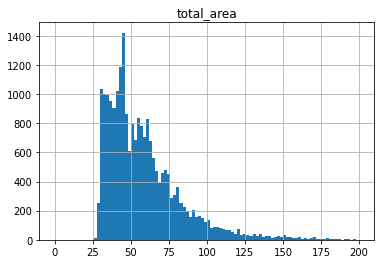

In [37]:
data.total_area.hist(bins=100, range=(0, 200))
plt.title('total_area')
plt.show()

**Вывод:** Большинство квартик в выбоке имеют площадь в диапозоне от 26 до 60 кв.м.  

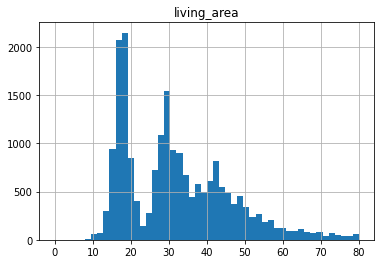

In [38]:
data.living_area.hist(bins=50, range=(0, 80))
plt.title('living_area')
plt.show()

**Вывод:** Можно наблюдать два пика на гистаграмме, причем кажется что есть выбросы у 30 кв.м. и на 35 кв.м.

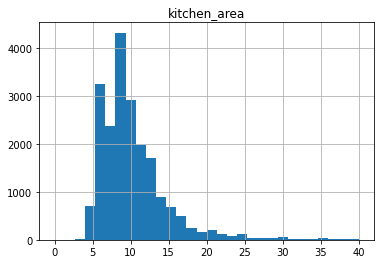

In [39]:
data.kitchen_area.hist(bins=30, range=(0, 40))
plt.title('kitchen_area')
plt.show()

**Вывод:** Размер кухонь от 5 до 15 кв.м.

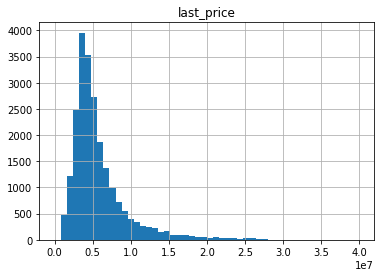

In [40]:
data.last_price.hist(bins=50,  range=(0, 40000000))
plt.title('last_price')
plt.show()

**Вывод:** Цена на квартиры от 1.5 млн до 10 млн 

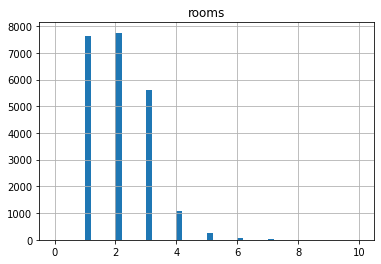

In [41]:
data.rooms.hist(bins=50, range=(0, 10))
plt.title('rooms')
plt.show()

**Вывод:** Чаще всего в выборке встречабтся квартиры с 1 - 3 комнатами.

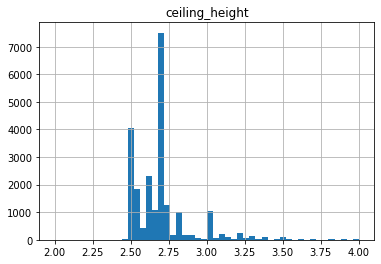

In [42]:
data.ceiling_height.hist(bins=50, range=(2, 4))
plt.title('ceiling_height')
plt.show()

**Вывод:** Высота потолков для большинства квартир примерно 2.5 и 2.6 метра

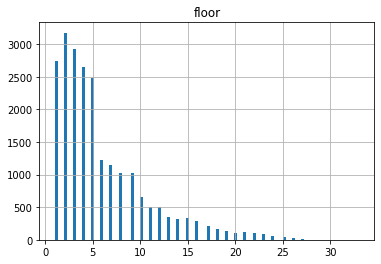

In [43]:
data.floor.hist(bins=100)
plt.title('floor')
plt.show()

**Вывод:** Чем выше находиться квартира тем менее охотно ее продают

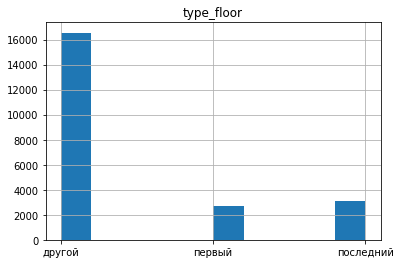

In [44]:
data.type_floor.hist()
plt.title('type_floor')
plt.show()

**Вывод:** В Выборка в основном сотоит из квартир не на первом и не на последнем этаже.

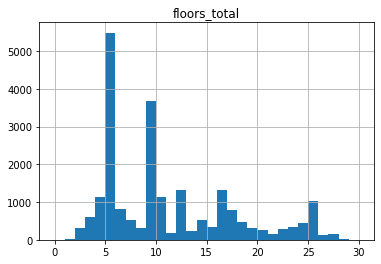

In [45]:
data.floors_total.hist(bins=30, range=(0, 30))
plt.title('floors_total')
plt.show()

**Вывод:** Чаще всего продают квартиры в домах с 5, 10, 16 и 25 этажами.

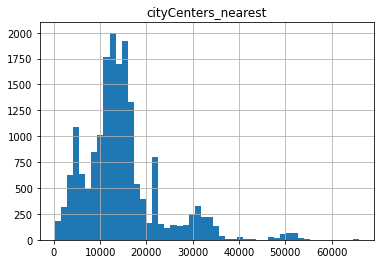

In [46]:
data.cityCenters_nearest.hist(bins=50)
plt.title('cityCenters_nearest')
plt.show()

**Вывод:** Большинство квартир расположено в 5 - 17 км от центра города

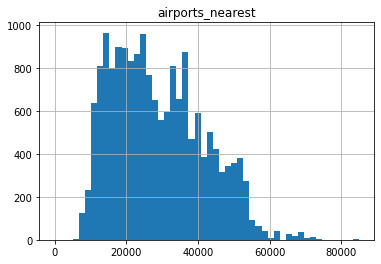

In [47]:
data.airports_nearest.hist(bins=50)
plt.title('airports_nearest')
plt.show()

**Вывод:** Квартиры по своей большей части удалены от аэропортов на 10 - 55 км.

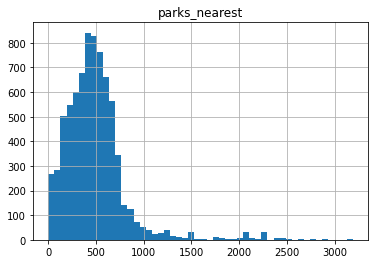

In [48]:
data.parks_nearest.hist(bins=50)
plt.title('parks_nearest')
plt.show()

 **Вывод:** Наиболее часто встречающаяся в выборке удаленность квартир от парка колеблится в диапозоне от 100 до 600 м.

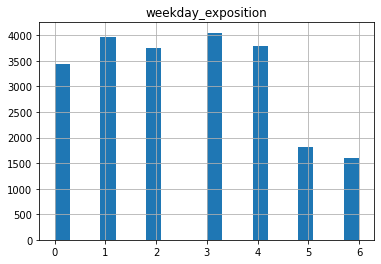

In [49]:
data.weekday_exposition.hist(bins=20)
plt.title('weekday_exposition')
plt.show()

**Вывод:** Реже всего объявления размещают по выходным дням

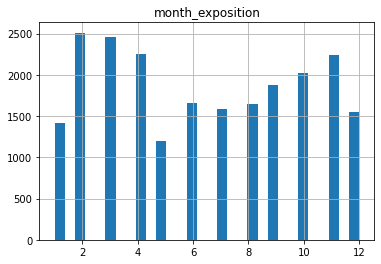

In [50]:
data.month_exposition.hist(bins=30)
plt.title('month_exposition')
plt.show()

**Вывод:** Наиболее популярные месяцы размещения объявлений это февраль, март, апрель и ноябрь.

#### Как быстро продавались квартиры

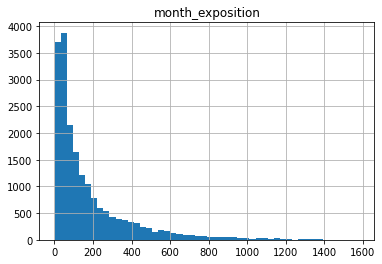

In [51]:
data.days_exposition.hist(bins=50)
plt.title('month_exposition')
plt.show()

In [52]:
print('Среднее значение:', data.days_exposition.mean())
print('Медиана:', data.days_exposition.median())

Среднее значение: 180.18796605811264
Медиана: 96.0


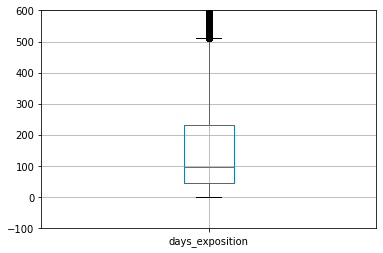

In [53]:
data.boxplot(column='days_exposition')
plt.ylim(-100, 600)
plt.show()

In [54]:
data.days_exposition.describe()

count    19445.000000
mean       180.187966
std        218.451099
min          1.000000
25%         45.000000
50%         96.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод:** <br>
* Продажа квартиры обычно занимает от 45 до 245 дней
* К быстрым продажам можно отнести продажии менее 45 дней
* К долгим продажам можно отнести продажи более 245 дней

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

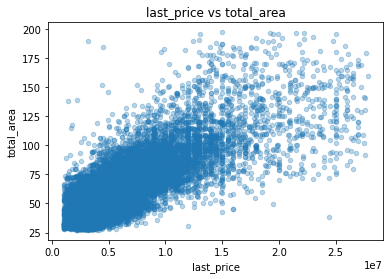

Корреляция: 0.7843044735125329


In [55]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3)
plt.title('last_price vs total_area')
plt.show()

print('Корреляция:', data.last_price.corr(data.total_area))

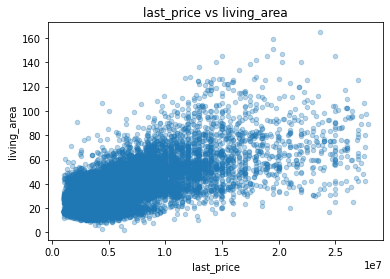

Корреляция: 0.6679681615765357


In [56]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3)
plt.title('last_price vs living_area')
plt.show()

print('Корреляция:', data.last_price.corr(data.living_area))

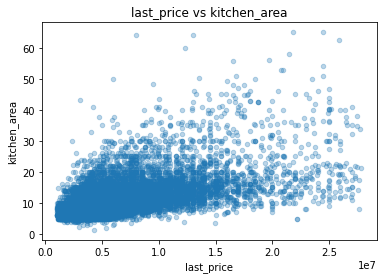

Корреляция: 0.5975859611852591


In [57]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3)
plt.title('last_price vs kitchen_area')
plt.show()

print('Корреляция:', data.last_price.corr(data.kitchen_area))

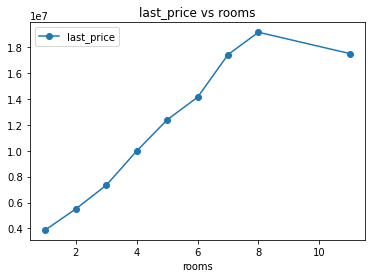

In [58]:
data.pivot_table(index='rooms', values='last_price').plot(marker='o')
plt.title('last_price vs rooms')
plt.show()

In [59]:
# data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3)
# plt.title('last_price vs rooms')
# plt.show()

# print('Корреляция:', data.last_price.corr(data.rooms))

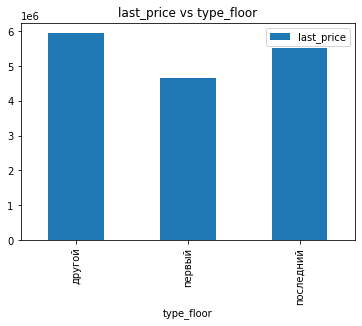

,last_price
type_floor,
другой,16548
первый,2729
последний,3129


In [60]:
data.pivot_table(index='type_floor', values='last_price').plot(kind='bar')
plt.title('last_price vs type_floor')
plt.show()

data.pivot_table(index='type_floor', values='last_price', aggfunc='count')

In [61]:
# data.plot(x='last_price', y='type_floor', kind='scatter', alpha=0.3)
# plt.title('last_price vs type_floor')
# plt.show()

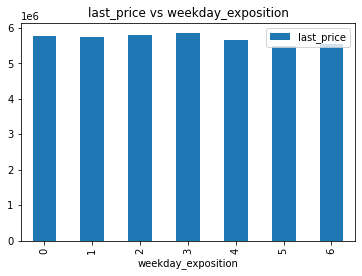

,last_price
weekday_exposition,
0,3430
1,3974
2,3751
3,4051
4,3788
5,1812
6,1600


In [62]:
data.pivot_table(index='weekday_exposition', values='last_price').plot(kind='bar')
plt.title('last_price vs weekday_exposition')
plt.show()

data.pivot_table(index='weekday_exposition', values='last_price', aggfunc='count')

In [63]:
# data.plot(x='last_price', y='weekday_exposition', kind='scatter', alpha=0.3)
# plt.title('last_price vs weekday_exposition')
# plt.show()

# print('Корреляция:', data.last_price.corr(data.weekday_exposition))

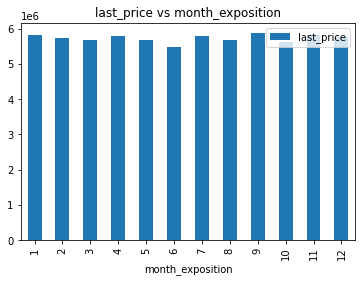

,last_price
month_exposition,
1,1411
2,2511
3,2453
4,2249
5,1196
6,1660
7,1591
8,1646
9,1873


In [64]:
data.pivot_table(index='month_exposition', values='last_price').plot(kind='bar')
plt.title('last_price vs month_exposition')
plt.show()

data.pivot_table(index='month_exposition', values='last_price', aggfunc='count')

In [65]:
# data.plot(x='last_price', y='month_exposition', kind='scatter', alpha=0.3)
# plt.title('last_price vs month_exposition')
# plt.show()

# print('Корреляция:', data.last_price.corr(data.month_exposition))

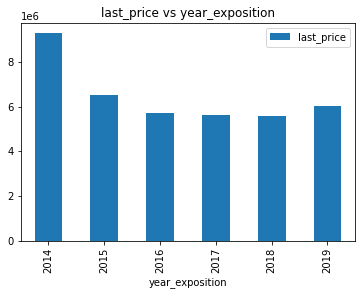

,last_price
year_exposition,
2014,127
2015,1110
2016,2614
2017,7759
2018,8069
2019,2727


In [66]:
data.pivot_table(index='year_exposition', values='last_price').plot(kind='bar')
plt.title('last_price vs year_exposition')
plt.show()

data.pivot_table(index='year_exposition', values='last_price', aggfunc='count')

In [67]:
# data.plot(x='last_price', y='year_exposition', kind='scatter', alpha=0.3)
# plt.title('last_price vs year_exposition')
# plt.show()

# print('Корреляция:', data.last_price.corr(data.year_exposition))

**Вывод:** <br>
* На стоимость квартиры больше всего влияет общая площадь и этаж, на котором расположена квартира
* Говорить о влияние года на цену квартиры довольно проблемотично, т.к. 2014 и 2015 имеют мало наблюдений в отличии от 2016 - 2019

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [68]:
top_advert = \
    data.groupby('locality_name_adj')\
            .agg({'total_images' : 'count','price_sq_metre' : 'mean'})\
            .reset_index()\
            .rename(columns={'total_images': 'cnt', 'price_sq_metre' : 'mean_price_sq_metre'})\
            .sort_values('cnt', ascending=False)

In [69]:
top_advert.head(10)

,locality_name_adj,cnt,mean_price_sq_metre
202,Санкт-Петербург,14941,109996.405214
133,Мурино,523,84694.882716
263,Шушары,431,78047.965118
97,Кудрово,424,94567.393181
31,Всеволожск,388,68759.897978
184,Пушкин,359,102671.849567
83,Колпино,335,75258.548102
156,Парголово,322,90448.423806
38,Гатчина,304,68986.938001
32,Выборг,225,58361.403687


In [70]:
high_price_city = top_advert[top_advert.mean_price_sq_metre == top_advert.mean_price_sq_metre.min()]['locality_name_adj']
low_price_city = top_advert[top_advert.mean_price_sq_metre == top_advert.mean_price_sq_metre.max()]['locality_name_adj']

In [71]:
print('Населенные пункты с высокой стоимостью квадратного метра:', high_price_city.to_string(index=False))
print('Населенные пункты с низкой стоимостью квадратного метра:', low_price_city.to_string(index=False))

Населенные пункты с высокой стоимостью квадратного метра: Житково
Населенные пункты с низкой стоимостью квадратного метра: Зеленогорск


#### Выделимквартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра.

In [72]:
data_spb = data[data['locality_name_adj'] == 'Санкт-Петербург']
data_spb = data_spb[data_spb['cityCenters_nearest_km'] != 0]
data_spb['price_per_km'] = data_spb['last_price'] / data_spb['cityCenters_nearest_km']

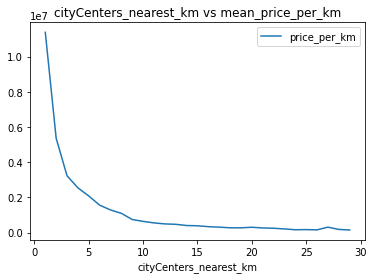

In [73]:
data_spb.pivot_table(index='cityCenters_nearest_km', values='price_per_km').plot()
plt.title('cityCenters_nearest_km vs mean_price_per_km')
plt.show()

In [74]:
print('Корреляция:', data_spb.price_per_km.corr(data_spb.cityCenters_nearest_km))

Корреляция: -0.5995570723463474


**Вывод:** <br>
С увеличением расстояния от центра города цена на квартиру уменьшается

### Общий вывод

Было проведено исследование, цель которого найти интересные особенности и зависимости, которые существуют на рынке недвижимости. Входные данные от сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические.

<br>

Необходимо было проверить несколько гипотез:
1. <ins>Гипотеза № 1</ins>:  Какие продажи можно считать быстрыми, а какие — необычно долгими?
2. <ins>Гипотеза № 2</ins>:  Какие факторы больше всего влияют на общую (полную) стоимость объекта?
3. <ins>Гипотеза № 3</ins>:  Как стоимость объектов зависит от расстояния до центра города.

<br>

Результаты исследования показали:

<br>

**Гипотеза № 1 подтверждена:** 
- Продажа квартиры обычно занимает от 45 до 245 дней
- К быстрым продажам можно отнести продажии менее 45 дней
- К долгим продажам можно отнести продажи более 245 дней

<br>

**Гипотеза № 2 частично подтверждена:** *(Возможно влияние года на цену квартиры но в 2014 и 2015 мало наблюдений)*
- На стоимость квартиры больше всего влияет общая площадь и этаж, на котором расположена квартира 
<br>

*Рекомедация:* провести дополнительные исследования на большей выборке  

<br>

**Гипотеза № 3 подтверждена:**
- С увеличением расстояния от центра города цена на квартиру уменьшается. (корреляция: -0.61)